In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
import datetime

In [3]:
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox

In [4]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [5]:
%matplotlib inline

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Read in data

In [7]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\"

In [8]:
data = pd.read_csv(Path(data_path) / 'covid19.csv')

In [9]:
data['Date'] = pd.to_datetime(data['Date'])

#### Plot

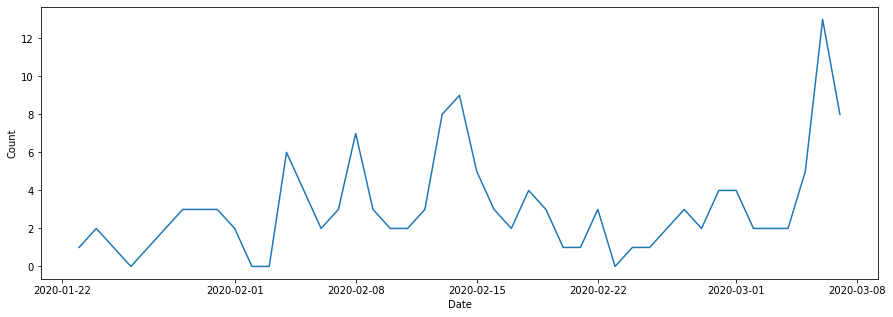

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='Count', data=data, kind='line', ax=ax)
plt.close()

#### Get subset of data

In [11]:
data_filter = (data['Date'] >= '2020-02-15') & (data['Date'] < '2020-04')

In [12]:
in_control_filter = (data['Date'] >= '2020-02-15') & (data['Date'] < '2020-03-06')

In [13]:
cutoff = '2020-02-15'

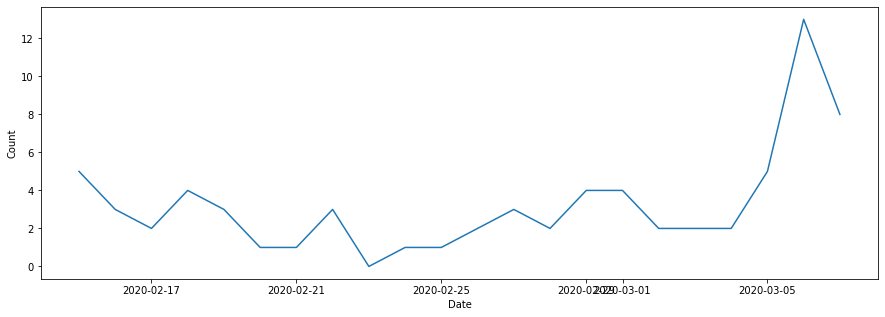

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='Count', data=data[data_filter], kind='line', ax=ax)
plt.close()

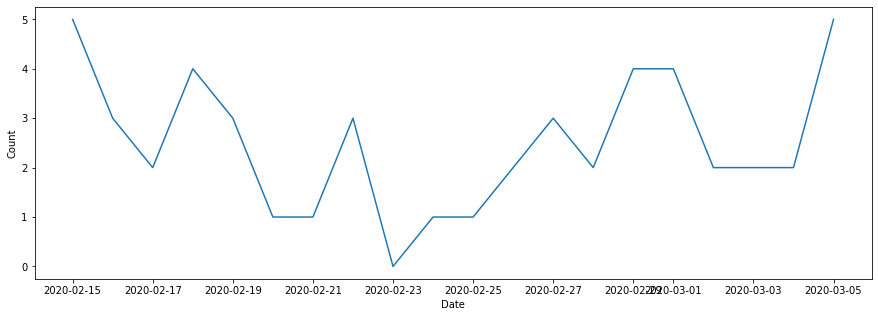

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='Count', data=data[in_control_filter], kind='line', ax=ax)
plt.close()

#### Hypothesis test

#### Auto correlation

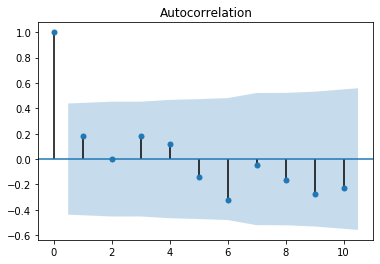

In [16]:
_ = plot_acf(data.loc[in_control_filter, 'Count'], lags=10)

In [17]:
st.ljungbox_(data.loc[in_control_filter, 'Count'], print_extra=True)

Statistics=12.367, p=0.261
No auto correlation up to lag 10 (fail to reject H0)


[ 0.77073161  0.77073161  1.63213753  2.03891255  2.62948962  5.93534373
  6.01105874  6.97526619 10.04502514 12.36715808]
[0.37999082 0.68020177 0.652125   0.72860177 0.75687974 0.43047182
 0.53845867 0.53930361 0.34685249 0.26123512]


#### Check if poisson distribution is appropriate

In [18]:
import scipy.stats as stats
import scipy as sp

In [19]:
sample_mean = data.loc[in_control_filter, 'Count'].mean()
sample_variance = data.loc[in_control_filter, 'Count'].var()

In [20]:
sample_mean

2.5

In [21]:
sample_variance

1.9473684210526316

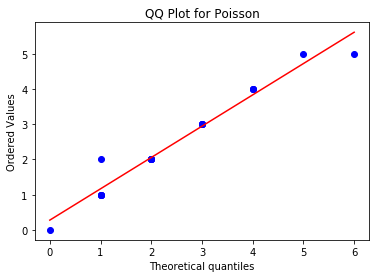

In [22]:
fig, ax = plt.subplots()
_ = stats.probplot(data.loc[in_control_filter, 'Count'], dist=stats.poisson, sparams=(sample_mean, ), plot=ax)
_ = plt.title('QQ Plot for Poisson')

#### Use Chisq goodness of fit

In [23]:
obs = data.loc[in_control_filter, 'Count']
obs_x = obs.sort_values().unique().tolist()

In [24]:
theoretical_freq = pd.Series(stats.poisson.pmf(obs_x, obs.mean()), index = obs_x)
obs_freq = obs.value_counts() / obs.value_counts().sum()

In [25]:
compare_df = pd.concat([theoretical_freq, obs_freq], axis=1)
compare_df.columns = ['theoretical_freq', 'obs_freq']

In [26]:
compare_df

,theoretical_freq,obs_freq
0,0.082085,0.05
1,0.205212,0.20
2,0.256516,0.30
3,0.213763,0.20
4,0.133602,0.15
5,0.066801,0.10


In [27]:
stats.chisquare(f_obs = compare_df.obs_freq, f_exp = compare_df.theoretical_freq)

Power_divergenceResult(statistic=0.039443315684262584, pvalue=0.9999837942806682)

#### Use Poisson Control Chart (C Chart)

In [28]:
c_chart_params_df = cp.c_chart_params(x = data.loc[data_filter, 'Count'], center=sample_mean)

In [29]:
c_chart_params_df = pd.concat([data.loc[data_filter, 'Date'].reset_index(drop=True), c_chart_params_df], axis=1)

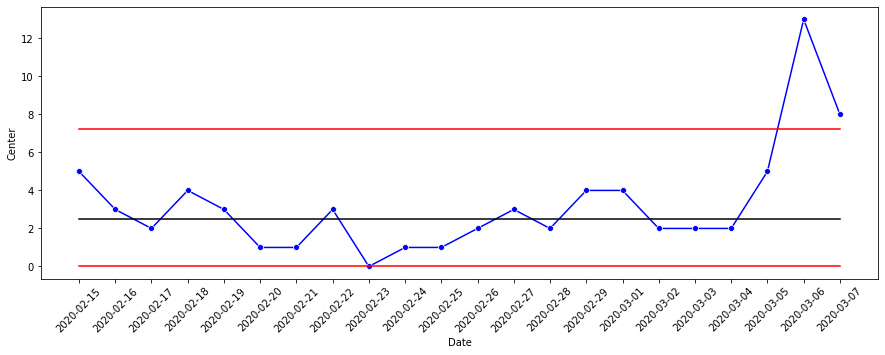

In [30]:
pf.plot_control_chart(
    data = c_chart_params_df,
    index = 'Date',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    all_dates=True,
    rot=45)